In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [3]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [4]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [5]:
# DataFrame for the count of each coffee item sold per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


In [6]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

,date,total_sales
0,2023-03-01,8645
1,2023-03-02,8560
2,2023-03-03,8690
3,2023-03-04,4365
4,2023-03-05,4565


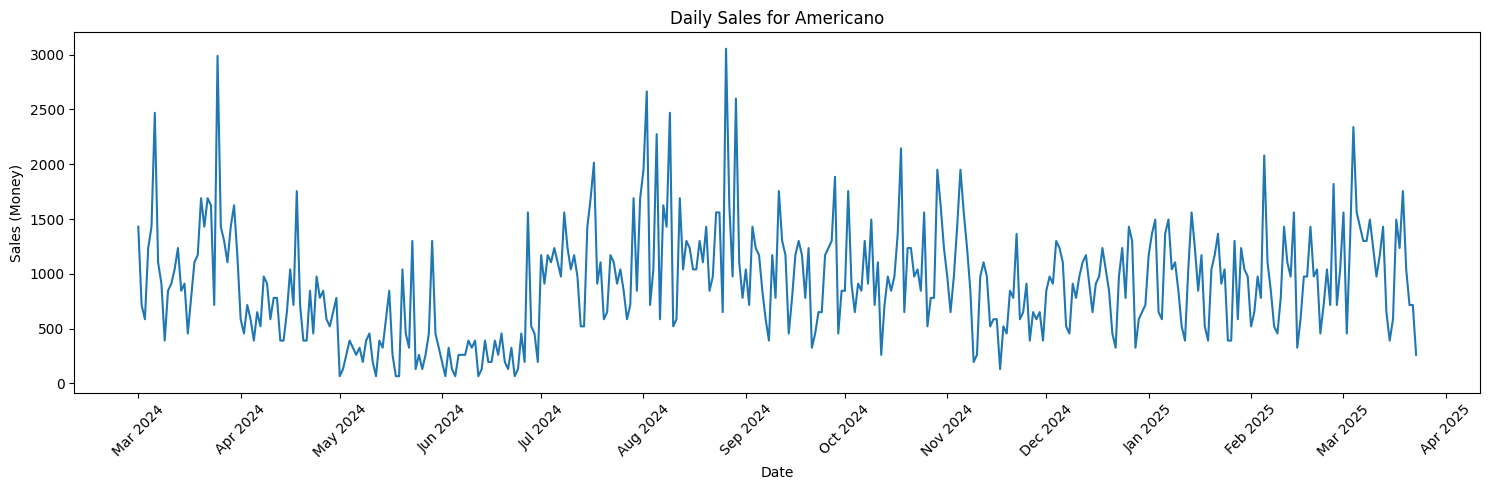

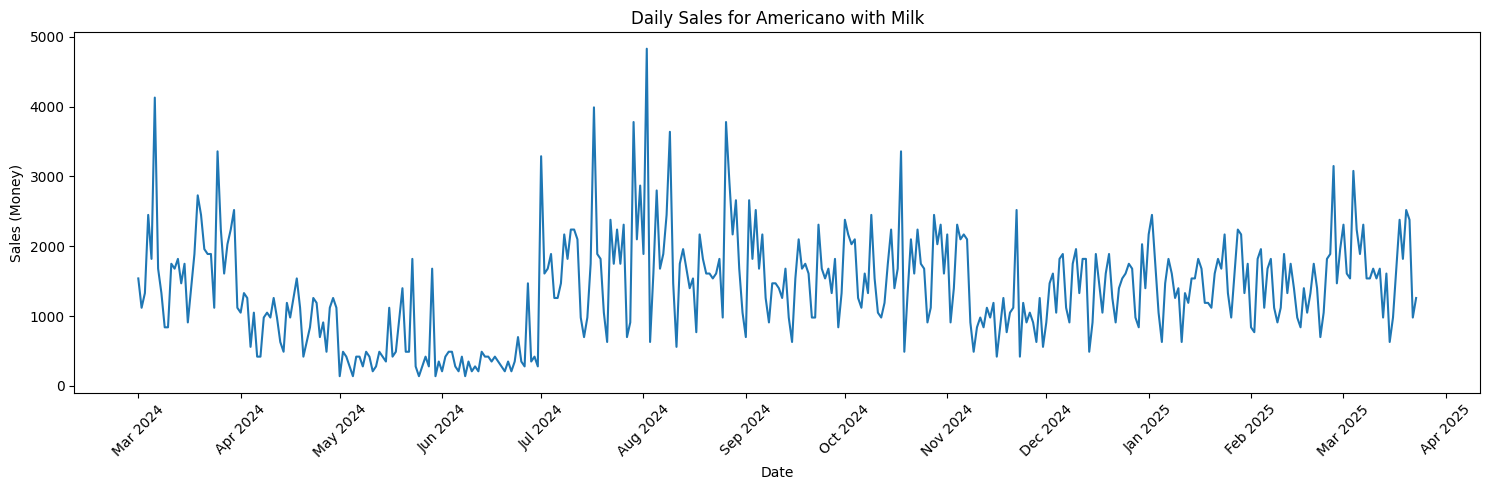

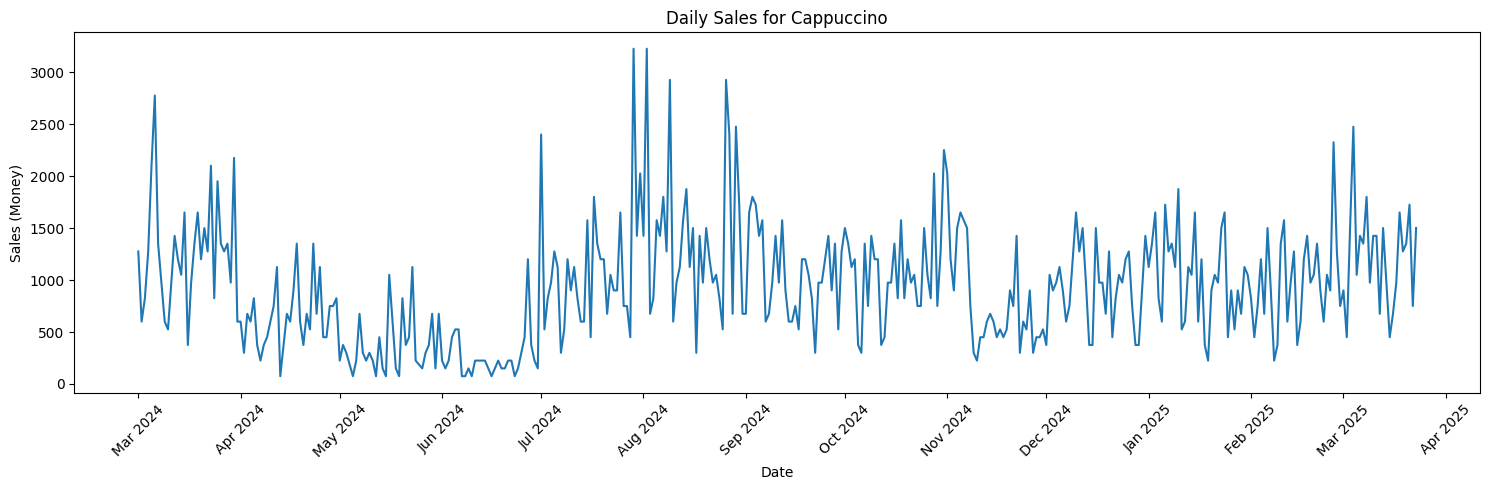

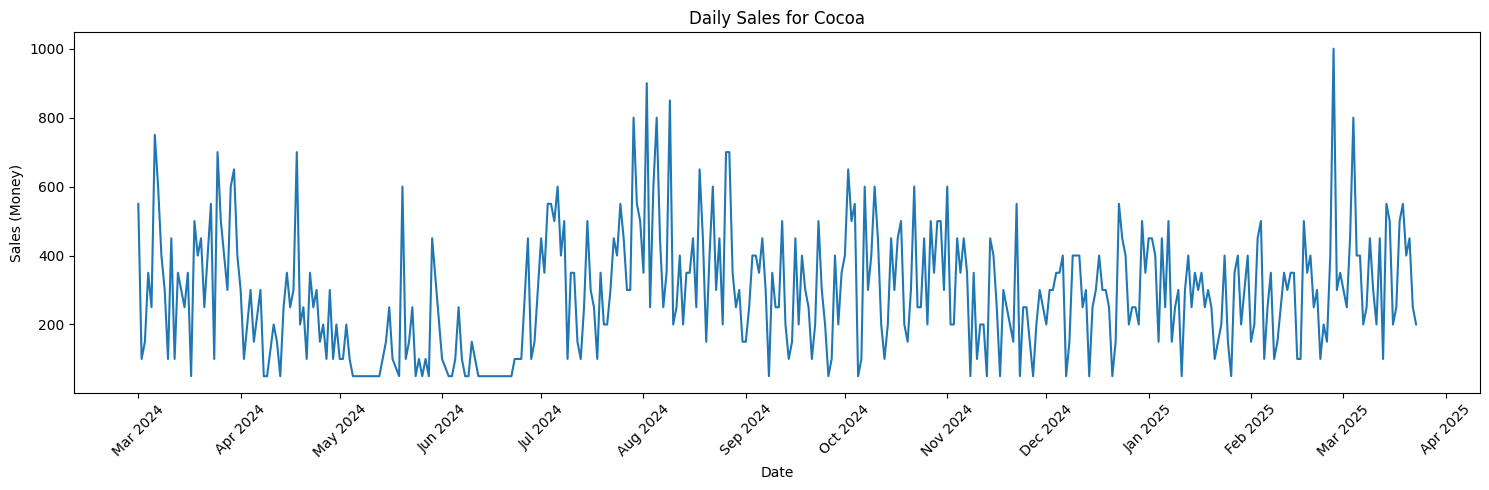

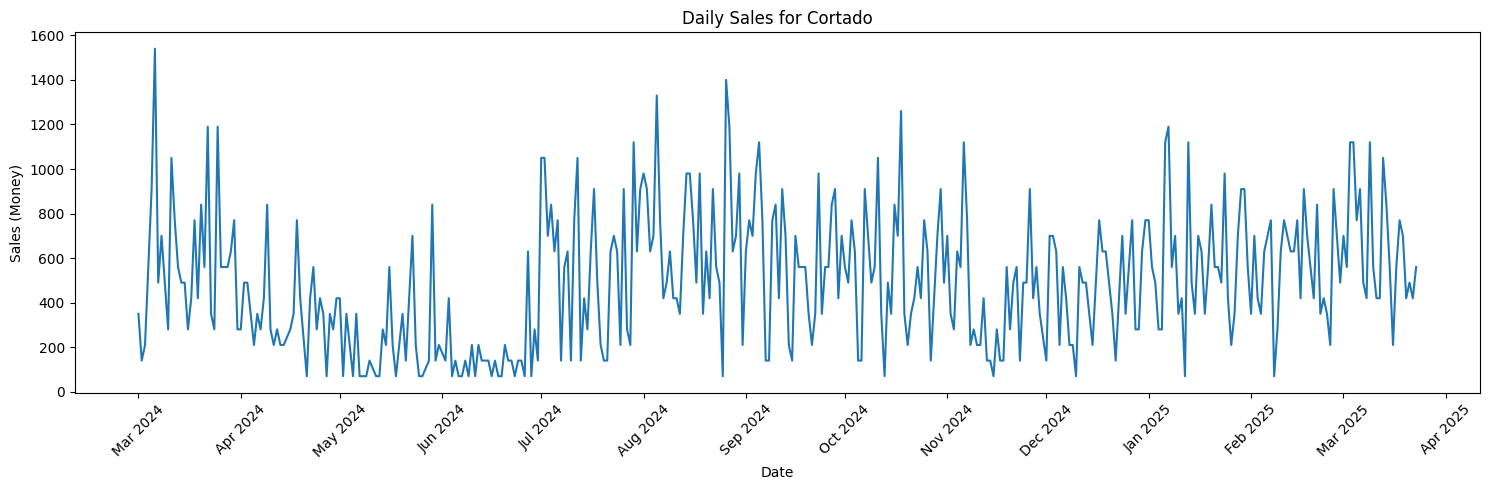

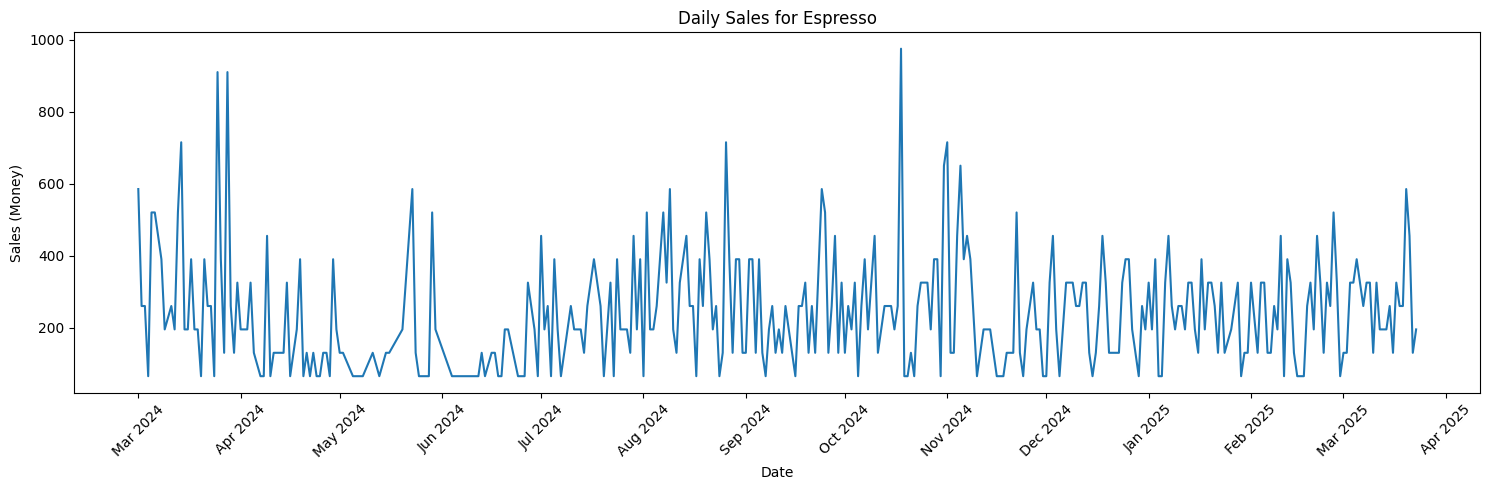

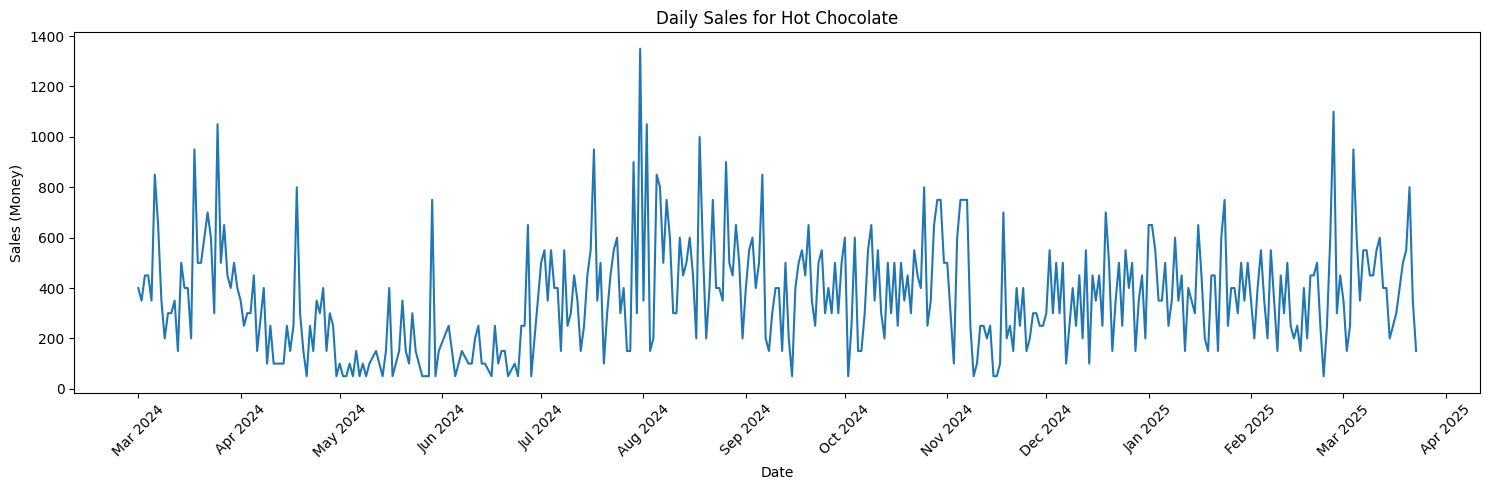

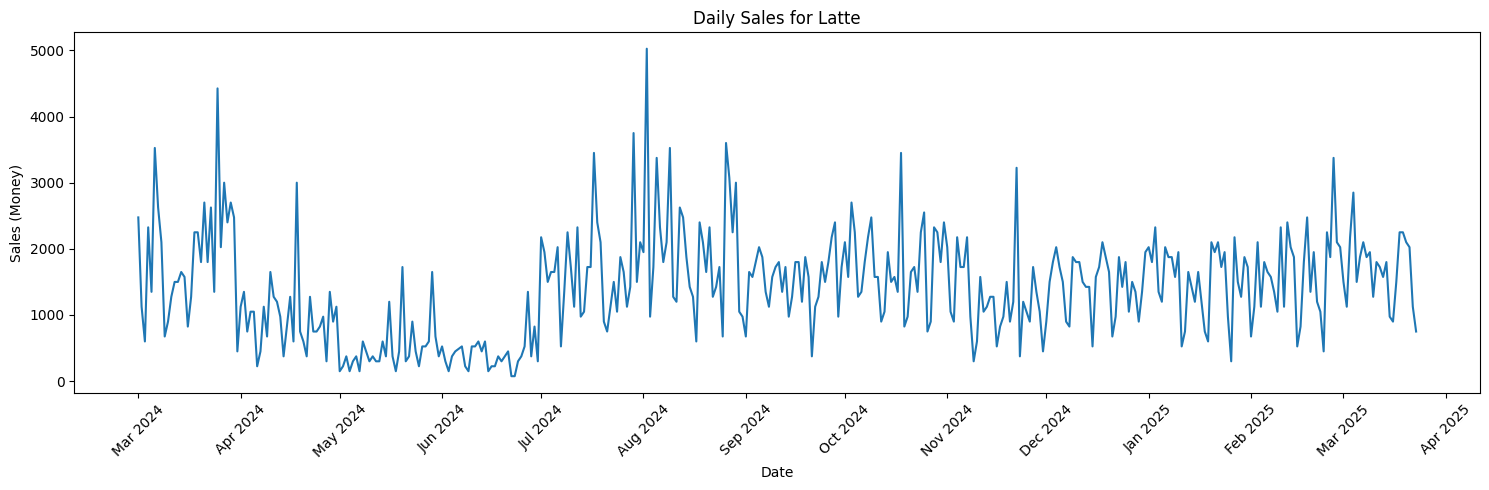

In [7]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_total_sales_features = create_sales_features(daily_total_sales.copy())


# Drop rows with NaN values created by lag features
daily_total_sales_features.dropna(inplace=True)

display(daily_total_sales_features.head())

,date,total_sales,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-15,7200,2,1,3,74,2023,7290.0,8645.0,6460.000000
15,2023-03-16,7315,3,1,3,75,2023,7140.0,8560.0,6447.142857
16,2023-03-17,7510,4,1,3,76,2023,7120.0,8690.0,6472.142857
17,2023-03-18,5250,5,1,3,77,2023,5735.0,4365.0,6527.857143
18,2023-03-19,4765,6,1,3,78,2023,3635.0,4565.0,6458.571429


In [9]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [10]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'

In [11]:
X = daily_total_sales_features[FEATURES]
y = daily_total_sales_features[TARGET]

In [12]:
# Determine the split date
split_date = '2025-03-01'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [13]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [15]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [17]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [18]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 1128.13 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 1035.21 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 366330.00 บาท


In [19]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

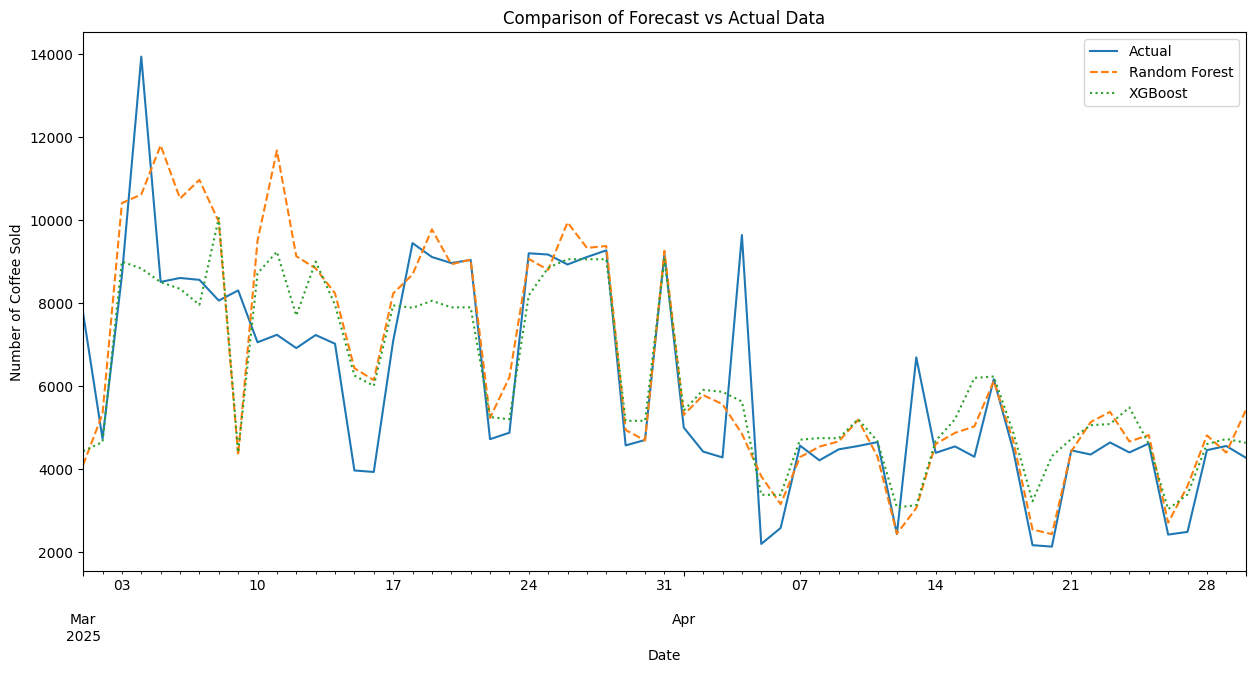

In [20]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [21]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

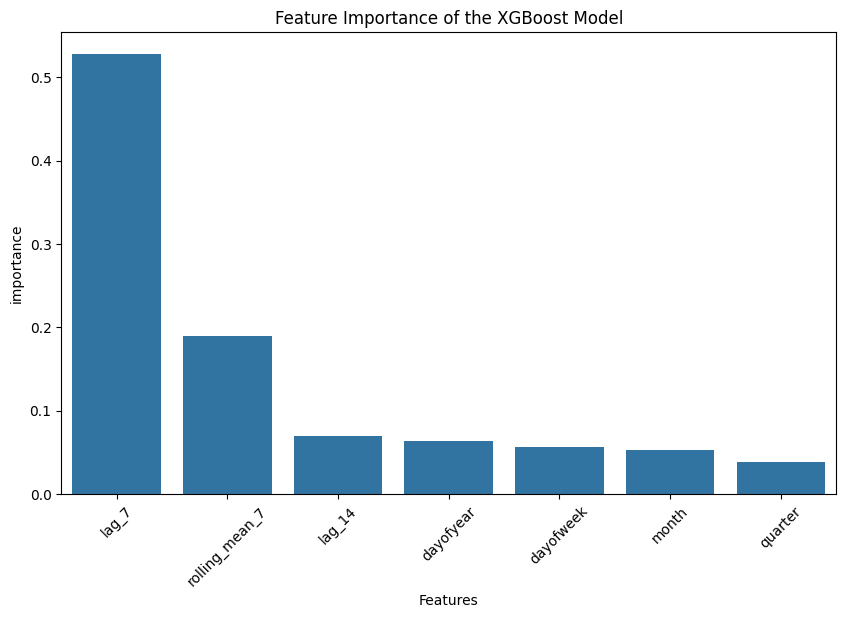

In [22]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

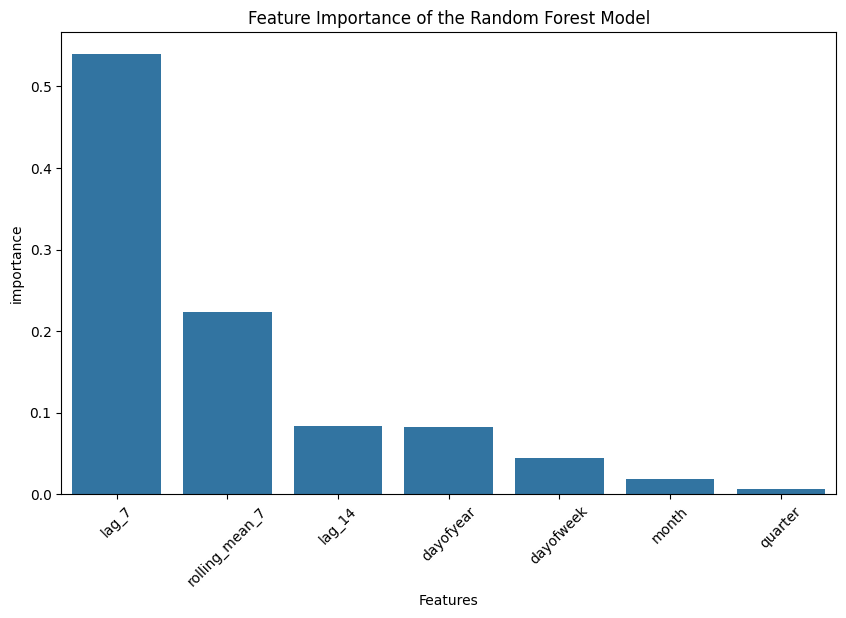

In [23]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [24]:
#ใช้  prophet

In [25]:
!pip install prophet

In [26]:
from prophet import Prophet

In [27]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [28]:
prophet_train = train_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})
prophet_test = test_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Prophet requires a continuous time series without missing dates.
# It's generally recommended to ensure the data has a daily frequency and fill missing dates if necessary.
# For simplicity now, we'll use the data as is, but note this for potential issues.
# If there are missing dates, Prophet can handle them to some extent but performance might be affected.

In [29]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpomt54_z2/3thmodct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpomt54_z2/95xisdp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76047', 'data', 'file=/tmp/tmpomt54_z2/3thmodct.json', 'init=/tmp/tmpomt54_z2/95xisdp_.json', 'output', 'file=/tmp/tmpomt54_z2/prophet_modelhxvg2owx/prophet_model-20250921125447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:54:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:54:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744,
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
       773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791],
      dtype='int64')

In [31]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [32]:
# Make predictions
forecast = model.predict(future)

In [33]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-15,9233.730622,7086.858239,11699.249804
1,2023-03-16,9251.532056,6935.519178,11529.666104
2,2023-03-17,8906.581304,6492.693773,11151.595466
3,2023-03-18,5968.444038,3750.698691,8421.902878
4,2023-03-19,6036.730926,3688.604890,8438.643053


In [34]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [35]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.2f} บาท")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 1180.71 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set (สำหรับ Prophet): 366330.00 บาท


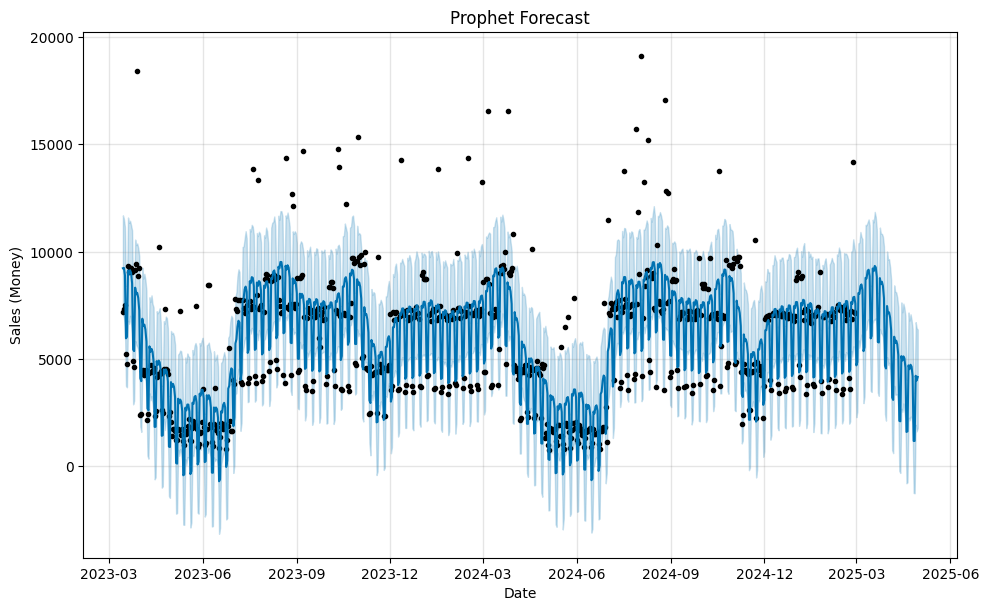

In [36]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

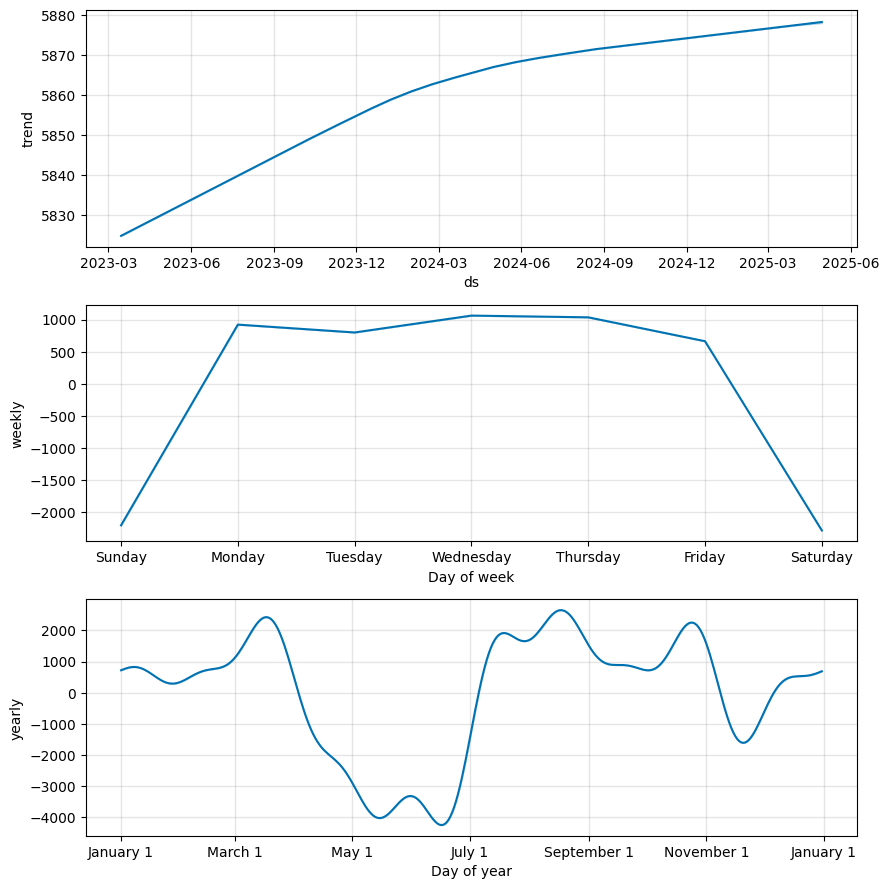

In [37]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [38]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-542g776f
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-542g776f
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-diul2u78/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [40]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [41]:
# Prepare the data for Chronos
# Chronos expects a torch tensor as input. We'll use the 'total_sales' column
# Filter data before the split date
split_date = pd.to_datetime('2025-03-01')
historical_sales_before_split = daily_total_sales[daily_total_sales['date'] < split_date].copy()


# Convert the 'total_sales' column from the filtered data to a torch tensor
context = torch.tensor(historical_sales_before_split['total_sales'].values)

# Define the prediction length (e.g., 60 days for one month forecast)
prediction_length = 60

# Make a forecast using the Chronos pipeline
forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
median_prediction = forecast[0].median(dim=0).values

# Display the median prediction
print(f"Chronos Median Forecast for the next {prediction_length} days:")
display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([3678.0229, 3722.3364, 6912.9102, 7001.5371, 7090.1641, 7090.1641,
        7045.8506, 3722.3364, 3722.3364, 6868.5967, 6912.9102, 7001.5371,
        7001.5371, 7045.8506, 3722.3364, 3633.7095, 6868.5967, 7134.4785,
        6957.2236, 7045.8506, 7001.5371, 3678.0229, 3678.0229, 6912.9102,
        6957.2236, 7045.8506, 7001.5371, 7045.8506, 3766.6499, 3633.7095,
        6957.2236, 7001.5371, 7001.5371, 6912.9102, 7001.5371, 4032.5312,
        3589.3960, 6824.2832, 7001.5371, 7045.8506, 7001.5371, 7001.5371,
        3855.2769, 3589.3960, 7001.5371, 7001.5371, 7001.5371, 7001.5371,
        6824.2832, 3766.6499, 3589.3960, 4652.9209, 6957.2236, 7001.5371,
        7001.5371, 6957.2236, 3678.0229, 3589.3960, 3766.6499, 6381.1484])

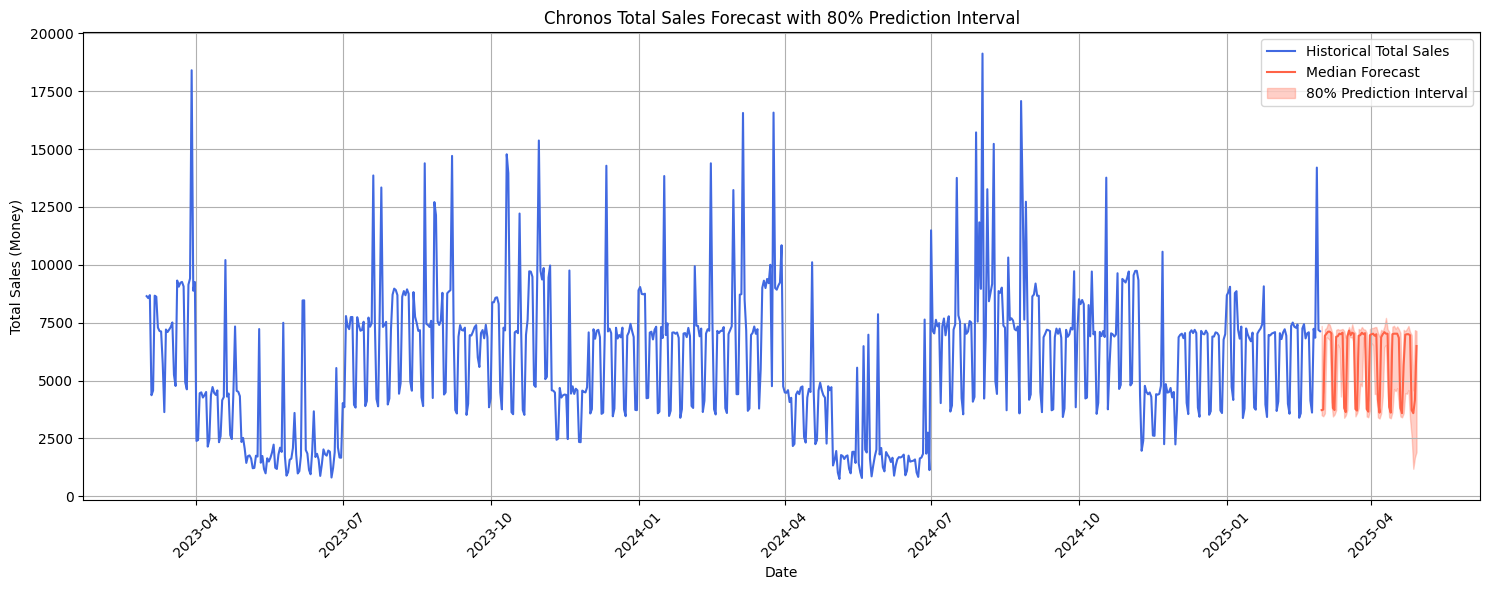

In [42]:
# Visualize the Chronos forecast with prediction interval
plt.figure(figsize=(15, 6))

# Plot historical data (daily_total_sales before split_date)
plt.plot(historical_sales_before_split['date'], historical_sales_before_split['total_sales'], color="royalblue", label="Historical Total Sales")

# Create dates for the forecast period
# The forecast starts immediately after the last date in the historical_sales_before_split
last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')

# Calculate quantiles for the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the median forecast
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

# Plot the 80% prediction interval
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.title('Chronos Total Sales Forecast with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales (Money)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
forecast[0][:][0]

tensor([3500.7686, 3456.4551, 7045.8506, 6868.5967, 7134.4785, 7311.7324,
        7045.8506, 3678.0229, 3633.7095, 6912.9102, 6912.9102, 6868.5967,
        6957.2236, 7090.1641, 3500.7686, 3722.3364, 7045.8506, 7045.8506,
        6868.5967, 7400.3594, 7001.5371, 3456.4551, 3678.0229, 7001.5371,
        3766.6499, 3766.6499, 6957.2236, 6735.6562, 3456.4551, 3678.0229,
        7045.8506, 6957.2236, 7090.1641, 7666.2402, 7799.1807, 7045.8506,
        7178.7920, 7178.7920, 6912.9102, 7311.7324, 7134.4785, 7178.7920,
        3766.6499, 3589.3960, 7311.7324, 7267.4189, 7223.1055, 7267.4189,
        7223.1055, 3943.9043, 4121.1582, 4519.9800, 4564.2935, 4519.9800,
        4785.8613, 4741.5479, 4564.2935, 4165.4717, 4519.9800, 4564.2935])

In [44]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[3722.3364 3744.4932 6935.067  7023.694  7112.3213 7112.3213 7045.8506
 3810.9636 3722.3364 6890.7534 6912.91   7023.694  7001.537  7068.0073
 3810.9636 3633.7095 6890.7534 7156.6353 6957.2236 7068.0073 7023.694
 3766.65   3700.1797 6935.067  6957.2236 7068.0073 7001.537  7045.8506
 3766.65   3655.8662 6957.2236 7001.537  7023.694  6935.067  7001.537
 4165.4717 3611.5527 6868.5967 7001.537  7090.1646 7023.694  7023.694
 3855.2769 3611.5527 7001.537  7023.694  7023.694  7023.694  6846.44
 3810.9634 3589.396  5672.132  6979.3804 7001.537  7001.537  6957.2236
 3722.3364 3589.396  4143.315  6491.932 ]


# Assignment week7

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

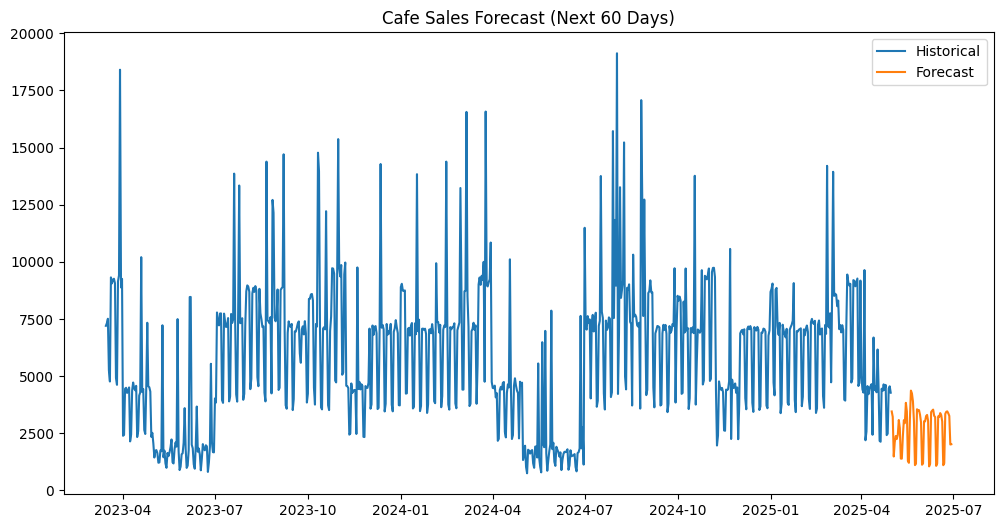

,date,total_sales
0,2025-05-01,3454.675
1,2025-05-02,3220.375
2,2025-05-03,1483.625
3,2025-05-04,2110.650
4,2025-05-05,2382.175


In [45]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


# ------------------------------
# 1) เตรียมข้อมูล
# ------------------------------

# สมมติว่ามี DataFrame daily_total_sales ที่มีคอลัมน์ ['date', 'total_sales']
df = daily_total_sales.copy()
df['date'] = pd.to_datetime(df['date'])                   # แปลงคอลัมน์ date ให้เป็น datetime
df = df.sort_values('date').reset_index(drop=True)        # เรียงข้อมูลตามเวลา


# ------------------------------
# 2) ฟังก์ชันสร้าง Features จากวันที่
# ------------------------------
def create_sales_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek             # วันในสัปดาห์ (0=จันทร์ ... 6=อาทิตย์)
    df['quarter'] = df['date'].dt.quarter                 # ไตรมาส
    df['month'] = df['date'].dt.month                     # เดือน
    df['dayofyear'] = df['date'].dt.dayofyear             # วันที่ที่เท่าไหร่ของปี
    df['lag_7'] = df['total_sales'].shift(7)              # ยอดขายย้อนหลัง 7 วัน
    df['lag_14'] = df['total_sales'].shift(14)            # ยอดขายย้อนหลัง 14 วัน
    df['rolling_mean_7'] = df['total_sales'].shift(7).rolling(7).mean()  # ค่าเฉลี่ย 7 วันย้อนหลัง
    return df

df = create_sales_features(df)
df = df.dropna().reset_index(drop=True)                   # ลบแถวที่มี NaN จากการทำ lag


# ------------------------------
# 3) กำหนด Features และ Target
# ------------------------------
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear',
            'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'


# ------------------------------
# 4) แบ่ง Train/Test
# ------------------------------
train = df.iloc[:-60]                                     # ข้อมูลก่อนหน้าเป็น train set
test = df.iloc[-60:]                                      # 60 วันสุดท้ายเป็น test set

X_train, y_train = train[FEATURES], train[TARGET]
X_test, y_test = test[FEATURES], test[TARGET]


# ------------------------------
# 5) สร้างและเทรนโมเดล
# ------------------------------
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


# ------------------------------
# 6) พยากรณ์อนาคต 60 วัน
# ------------------------------
future_days = 60
last_date = df['date'].max()

future_df = []                   # เก็บผลลัพธ์พยากรณ์
current_df = df.copy()           # ใช้ข้อมูลทั้งหมดเป็นฐานในการพยากรณ์

for i in range(1, future_days+1):
    next_date = last_date + pd.Timedelta(days=i)          # วันที่ถัดไป
    row = {
        'date': next_date,
        'dayofweek': next_date.dayofweek,
        'quarter': next_date.quarter,
        'month': next_date.month,
        'dayofyear': next_date.dayofyear,
    }

    # รวม row นี้เข้ากับข้อมูลเดิม เพื่อให้ lag/rolling ทำงานได้
    temp = current_df.copy()
    temp = pd.concat([temp, pd.DataFrame([row])], ignore_index=True)
    temp = create_sales_features(temp)
    new_row = temp.iloc[-1]                               # ดึงข้อมูลล่าสุด

    # พยากรณ์ด้วยโมเดล
    X_new = new_row[FEATURES].values.reshape(1, -1)
    y_pred = model.predict(X_new)[0]

    # เก็บค่าพยากรณ์ไว้ใน row
    row['total_sales'] = y_pred

    # อัปเดต current_df เพื่อใช้เป็น lag ต่อในรอบถัดไป
    current_df = pd.concat([current_df, pd.DataFrame([row])], ignore_index=True)
    future_df.append(row)

# รวมผลลัพธ์เป็น DataFrame
future_sales = pd.DataFrame(future_df)


# ------------------------------
# 7) แสดงผลลัพธ์
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['total_sales'], label="Historical")                     # ข้อมูลจริง
plt.plot(future_sales['date'], future_sales['total_sales'], label="Forecast")   # ข้อมูลพยากรณ์
plt.legend()
plt.title("Cafe Sales Forecast (Next 60 Days)")
plt.show()

# ดูผลลัพธ์พยากรณ์ 5 วันแรก
future_sales[['date', 'total_sales']].head()


In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [47]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [48]:
daily_sales = df.groupby("date")["total_sales"].sum().reset_index()
daily_sales = daily_sales.set_index("date").asfreq("D")
daily_sales["total_sales"] = daily_sales["total_sales"].interpolate()

In [49]:
model = ExponentialSmoothing(
    daily_sales["total_sales"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
)
fit = model.fit()

In [50]:
fit = model.fit()

In [51]:
forecast = fit.forecast(60)

In [52]:
result = pd.concat([daily_sales["total_sales"], forecast])

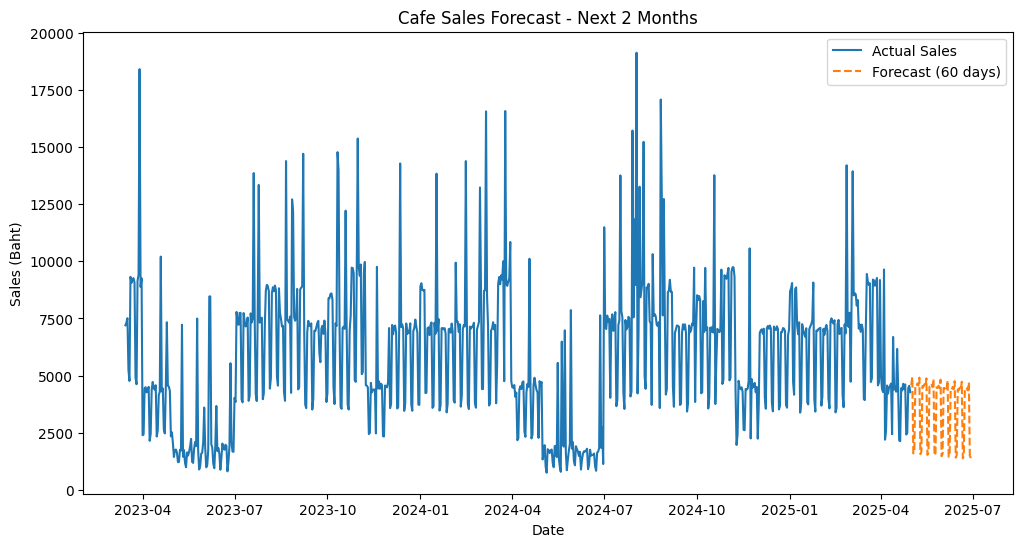

In [53]:
plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales["total_sales"], label="Actual Sales")
plt.plot(forecast.index, forecast, "--", label="Forecast (60 days)")
plt.title("Cafe Sales Forecast - Next 2 Months")
plt.xlabel("Date")
plt.ylabel("Sales (Baht)")
plt.legend()
plt.show()

In [54]:
forecast.to_csv("cafe_forecast_60days.csv", header=["forecast"])

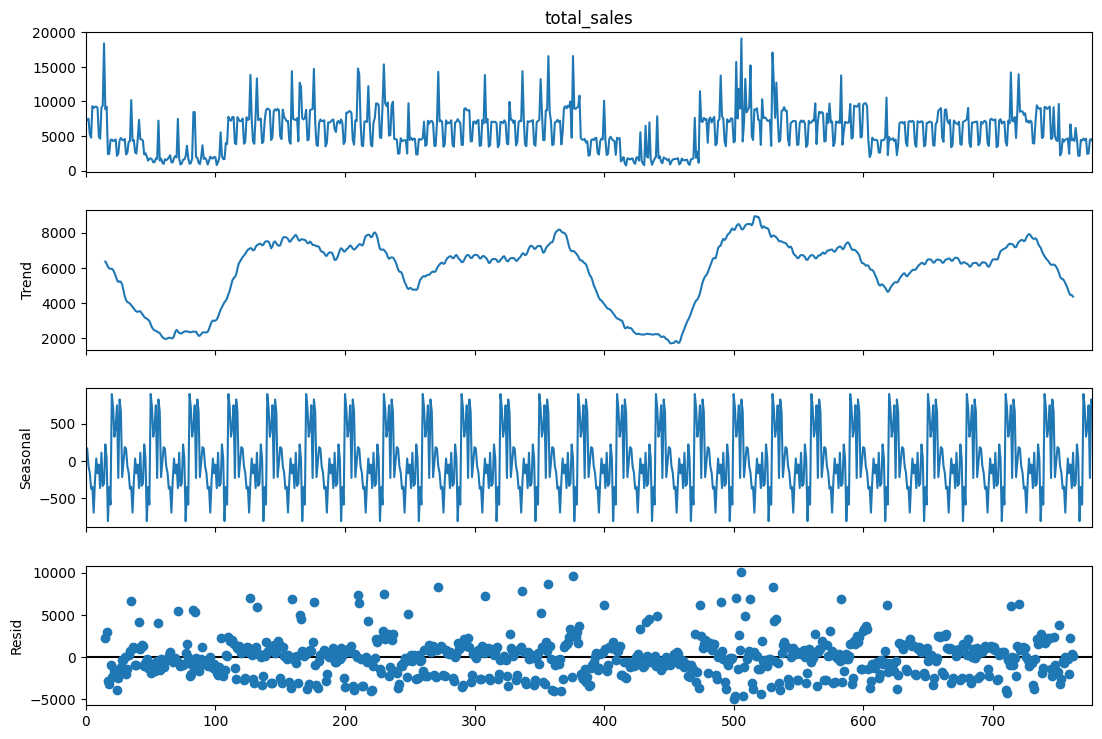

In [55]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ใช้คอลัมน์ total_sales ในการแยกส่วน
# period=30 หมายถึงประมาณ 1 เดือน (ถ้าข้อมูลเป็น daily)
result = seasonal_decompose(df['total_sales'], model='additive', period=30)

# วาดกราฟ decomposition
fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()


In [59]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# 1️⃣ สร้างโมเดลและ fit
model = ARIMA(y_train, order=(1,1,1))  # ปรับ order ตามที่คุณใช้จริง
model_fit = model.fit()

# 2️⃣ พยากรณ์ test set
y_pred_test = model_fit.forecast(len(y_test))

# 3️⃣ คำนวณ MAE
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE:", mae)


MAE: 2407.9803900280067
